# Importing Libraries

In [1]:
import math
import numpy as np

In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

In [2]:
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_distribution
import qiskit.circuit.library as qulib
from qiskit_aer import AerSimulator
from qiskit.result import marginal_distribution
from qiskit import transpile

In [30]:
def TridiagonalBlockEncoding(m,arr):
    """
    Inputs:
    m: number of qubits of operator
    arr: array of size 3 with the values of the diagonal and sub-diagonal elements
    arr[0]: super-diagonal element (gamma)
    arr[1]: diagonal element (alpha)
    arr[2]: sub-diagonal element (beta)

    Outputs:
    Tridiagblckencd: QuantumCircuit object representing the block encoding of the tridiagonal matrix
    """

    # Sparse Block encoding according to paper van Daan Camps 2023 Explicit block encoding of sparse matrices
    n = 2 # Number of Ancilla Qubits

    Tridiagblckencd = QuantumCircuit(n+m+1,name="Tridiagblckencd")

    # Diffusion Operator
    Diffusion = QuantumCircuit(n,name="Diffusion")
    Diffusion.h(range(n))
    Tridiagblckencd.append(Diffusion, list(range(1,n+1)))

    #OA circuit
    OA = QuantumCircuit(n+m+1,name="OA")
    theta0=2*np.arccos(arr[1]-1)
    theta1=2*np.arccos(arr[2])
    theta2=2*np.arccos(arr[0])
    
    # print(theta2)
    # print(theta0)
    # print(theta1)
    
    OA.append(qulib.RYGate(theta0).control(2,ctrl_state="00"),[2,1,0])
    OA.append(qulib.RYGate(theta1).control(2,ctrl_state="01"),[2,1,0])
    OA.append(qulib.RYGate(theta2).control(2,ctrl_state="10"),[2,1,0])
    str="01"+"1"*m
    OA.append(qulib.RYGate(np.pi - theta1).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))
    str="10"+"0"*m
    OA.append(qulib.RYGate(np.pi - theta2).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))

    Tridiagblckencd.append(OA, list(range(0,n+m+1)))
    
    #Oc Circuit
    Oc = QuantumCircuit(n+m,name="Oc")
    #Lshift Operator
    Lshift = QuantumCircuit(m,name="Lshift")
    for i in range(m-1):
        Lshift.append(qulib.XGate().control(m-i-1),list(range(m-1,i-1,-1)))
    Lshift.x(m-1)
    Oc.append(qulib.UnitaryGate(Operator(Lshift),label="Lshift").control(1),[1]+list(range(n,n+m)))
    
    #RShift Operator
    Rshift = QuantumCircuit(m,name="Rshift")
    for i in range(m-1):
        str='0'*(m-i-1)
        Rshift.append(qulib.XGate().control(m-i-1,ctrl_state=str),list(range(m-1,i-1,-1)))
    Rshift.x(m-1)
    Oc.append(qulib.UnitaryGate(Operator(Rshift),label="Rshift").control(1),[0]+list(range(n,n+m)))
   
    Tridiagblckencd.append(Oc, list(range(1,n+m+1)))

    # Diffusion Operator
    Tridiagblckencd.append(Diffusion, list(range(1,n+1)))
    
    return Tridiagblckencd
    

## Parameters

In [35]:
# Required conditions
m = 2 # n = 5 number of qubits chosen to implement the matrix, M = 2**m
normalizing_factor = 1.6 # divide by this parameter to make the matrix spectral norm less than 1
M = 2**m # Dimension of the matrix
s = 3 # Sparsity
r = int(np.ceil(np.log2(s)))

# Matrix Parameters
Vx = -0.5 # Vx chosen
alpha = 1 + Vx # Diagonal entry
beta = -0.5 # sub-diagonal entry
gamma= -0.5 # Super-diagonal entry

print("Dimension of Matrix: ",M)
print("Sparsity: ",s)
print("Number of Ancilla qubits: ", r+1)
print("Total Number of Qubits: ", m+r+1)

Dimension of Matrix:  4
Sparsity:  3
Number of Ancilla qubits:  3
Total Number of Qubits:  5


Note that both the constraints for block encoding of general s-sparse matrix which are $\|A\|_{max} = \max_{ij} |A_{ij}| \leq 1$ and $\|A\|_2 \leq 1$ are followed. 

In [36]:
super_diag = np.ones(M-1) * gamma
main_diag = np.ones(M) * alpha
sub_diag = np.ones(M-1) * beta

tridiag_A = np.diag(main_diag) + np.diag(sub_diag, k=-1) + np.diag(super_diag, k=1)
tridiag_A = tridiag_A/normalizing_factor
print("The matrix is:\n", tridiag_A)
print("The matrix spectral Norm is: ",np.linalg.norm(tridiag_A,ord=2))
print(" The maximum value in the matrix is: ", np.max(tridiag_A))
print("The minimum value in the matrix is: ", np.min(tridiag_A))

The matrix is:
 [[ 0.3125 -0.3125  0.      0.    ]
 [-0.3125  0.3125 -0.3125  0.    ]
 [ 0.     -0.3125  0.3125 -0.3125]
 [ 0.      0.     -0.3125  0.3125]]
The matrix spectral Norm is:  0.8181356214843422
 The maximum value in the matrix is:  0.3125
The minimum value in the matrix is:  -0.3125


#### Solving Eigenvalue problem classically, 
we have to diagonalize the matrix of size $2^m \times 2^m$ where $m$ is the number of qubits. This is computationally expensive and not feasible for large $m$.

In [37]:
#Eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(tridiag_A)
print("Eigenvalues of A:")
print(eigenvalues)
print("Eigenvectors of A:")
print(eigenvectors)

Eigenvalues of A:
[-0.19313562  0.11936438  0.50563562  0.81813562]
Eigenvectors of A:
[[-0.37174803  0.60150096  0.60150096 -0.37174803]
 [-0.60150096  0.37174803 -0.37174803  0.60150096]
 [-0.60150096 -0.37174803 -0.37174803 -0.60150096]
 [-0.37174803 -0.60150096  0.60150096  0.37174803]]


In [38]:
# Singular Value Decomposition
U, sigma, V = np.linalg.svd(tridiag_A)
print("U = \n",U)
print("V = \n",V)
print("Sigma = \n",sigma)

U = 
 [[-0.37174803 -0.60150096  0.37174803  0.60150096]
 [ 0.60150096  0.37174803  0.60150096  0.37174803]
 [-0.60150096  0.37174803  0.60150096 -0.37174803]
 [ 0.37174803 -0.60150096  0.37174803 -0.60150096]]
V = 
 [[-0.37174803  0.60150096 -0.60150096  0.37174803]
 [-0.60150096  0.37174803  0.37174803 -0.60150096]
 [-0.37174803 -0.60150096 -0.60150096 -0.37174803]
 [ 0.60150096  0.37174803 -0.37174803 -0.60150096]]
Sigma = 
 [0.81813562 0.50563562 0.19313562 0.11936438]


# Simulator

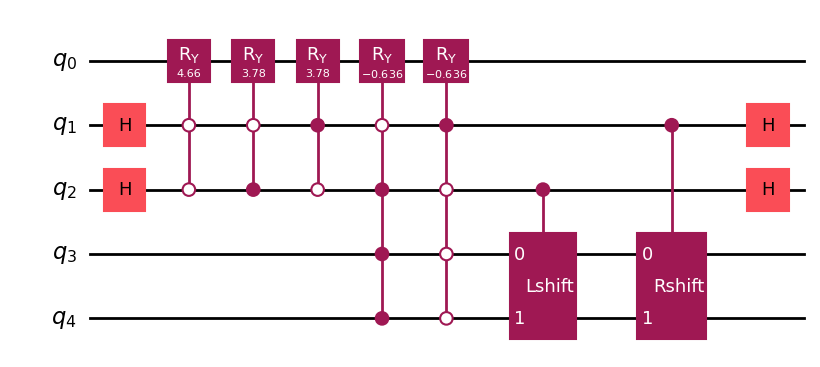

In [39]:
# backend = AerSimulator()

qc = QuantumCircuit(m+r+1,name="tridiagBE")
circuit = TridiagonalBlockEncoding(m,[tridiag_A[0,1],tridiag_A[0,0],tridiag_A[1,0]])
qc.append(circuit,list(range(0,m+r+1)))
# qc.measure(list(range(0,r+1)),list(range(0,r+1)))

circuit.decompose().draw('mpl')

## Verification through inner products !!! $Need to check$

In [45]:
i = 0
j = 10

print((format(1, f'0{m}b'))[::-1])
keti = Statevector.from_label((format(i, f'0{m}b'))[::-1])
ketj = Statevector.from_label((format(j, f'0{m}b'))[::-1])
print(keti)
print(ketj)

# Take tensor product of i with ket 0
ket0 = Statevector.from_label('0')
ket0r = Statevector.from_label('0'*r)

print((((ket0.tensor(ket0r)).tensor(keti)).evolve(qc)).inner((ket0.tensor(ket0r)).tensor(ketj)))

10
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


QiskitError: 'Statevector dimensions do not match: (2, 2, 2, 2, 2) and (2, 2, 2, 2, 2, 2, 2).'

In [43]:
keti = Statevector.from_label((format(i, f'0{m}b'))[::-1])
ketj = Statevector.from_label((format(j, f'0{m}b'))[::-1])

In [54]:
psi_0 = Statevector.from_label('0'*m+'0'*r+'0')
# psi_0.draw("latex")
psi_f = psi_0.evolve(qc)
psi_f.draw('latex')


# Expand the output
amplitudes = psi_f.data
num_qubits = len(psi_f.dims())
basis_states = [format(i, f'0{num_qubits}b') for i in range(2**num_qubits)]

# Print the expanded output
for amplitude, basis_state in zip(amplitudes, basis_states):
    if abs(amplitude) > 1e-10:  # Filter out very small amplitudes
        print(f'{amplitude:.10f} |{basis_state}>')

0.0781250000-0.0000000000j |00000>
0.1815460944+0.0000000000j |00001>
-0.4218750000+0.0000000000j |00010>
0.1815460944+0.0000000000j |00011>
-0.4218750000+0.0000000000j |00100>
0.1815460944+0.0000000000j |00101>
0.0781250000-0.0000000000j |00110>
0.1815460944+0.0000000000j |00111>
-0.0781250000-0.0000000000j |10000>
0.2374794399-0.0000000000j |10001>
-0.0781250000-0.0000000000j |10010>
0.2374794399+0.0000000000j |10011>
0.0781250000+0.0000000000j |10100>
-0.2374794399-0.0000000000j |10101>
0.0781250000+0.0000000000j |10110>
-0.2374794399-0.0000000000j |10111>
0.2500000000-0.0000000000j |11001>
-0.2500000000+0.0000000000j |11011>
0.2500000000-0.0000000000j |11101>
-0.2500000000+0.0000000000j |11111>


In [52]:
(Operator(circuit).data)[1
                         ,1]

np.complex128(0.07812499999999867-5.548944987594835e-16j)